# Installation & Setup

Install some python packages

In [1]:
%pip install us
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install plotnine

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import those packages

In [2]:
# Inline Chart Parameters
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import pandas as pd
import numpy as np
import us
from datetime import datetime, timedelta
from plotnine import *

# Display all columns on tables
pd.set_option('display.max_columns', None)

In [3]:
# Download some data
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/raw-polls.csv")\
  .to_csv('raw-polls.csv', index=False)

# Download some data
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/pollster-ratings.csv")\
  .to_csv('pollster-ratings.csv', index=False)

# Thinking About An Upcoming Election

Can we trust the polls? And if so...how much?

Here is an example of some polling data aggregated by FiveThirtyEight:
https://projects.fivethirtyeight.com/polls

Let's see how polls have been doing so far!

## Getting some data

Today we'll be working with data from [FiveThirtyEight's Pollster Ratings project](http://projects.fivethirtyeight.com/pollster-ratings/). 

This data contains:
* Every poll that FiveThirtyEight has collected in the last 21 days prior to general election (pres, senate, house, governor) or presidential primary.
* And... results for those elections!

In [4]:
# Load some data into variables
polls = pd.read_csv('raw-polls.csv')

# Reverses some values so that Democratic is on the left (-) and Republican is on the right (+)
polls['margin_poll'] = -polls['margin_poll']
polls['margin_actual'] = -polls['margin_actual']
polls['bias'] = -polls['bias']
polls['bias_overestimate'] = polls.bias.apply(lambda x: 'overestimates democrat' if x < 0 else 'overestimates republican')
polls['bias_overestimate'] = pd.Categorical(polls['bias_overestimate'], categories=['overestimates republican','overestimates democrat'])

# Create a variable to distinguish national vs state polls and for winner party
polls['national'] = polls.location.apply(lambda x: 'national' if x == 'US' else 'state')
polls['winner_party'] = polls.margin_actual.apply(lambda x: 'D' if x < 0 else 'R')
polls['winner_party'] = pd.Categorical(polls['winner_party'], categories=['R','D'])

polls.tail(2)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party
10774,73992,138821,8737,2020,2020_Sen-GR_GA,GA,Sen-G,Sen-GR,Opinion Savvy/InsiderAdvantage,243,IVR/Live Phone,NaN,1/3/2021,500.0,Jon Ossoff,14567,DEM,48.6,David A. Perdue,14568,REP,48.7,NaN,0.1,1/5/2021,50.61,49.39,-1.23,1.33,1.33,0.0,-1.85676,for Fox 5 Atlanta,overestimates republican,state,D
10775,74006,138845,8737,2020,2020_Sen-GR_GA,GA,Sen-G,Sen-GR,Trafalgar Group,338,IVR/Online/Text,R,1/3/2021,1056.0,Jon Ossoff,14567,DEM,49.4,David A. Perdue,14568,REP,48.5,NaN,-0.9,1/5/2021,50.61,49.39,-1.23,0.33,0.33,1.0,-2.37262,for unspecified Republican sponsor,overestimates republican,state,D


## Nationwide Presidential Polls

Lets look at polls of the Nationwide popular vote. First, an exploratory visualization.

In [5]:
# Get all NATIONAL-level presidential polls
polls_to_analyze = polls.query("type_detail=='Pres-G' and location=='US'")

# Display 3 random polls
polls_to_analyze.sample(3)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party
815,28073,121984,40,2000,2000_Pres-G_US,US,Pres-G,Pres-G,CBS News/The New York Times,36,Live Phone,NaN,10/30/2000,782.5,Al Gore,222,DEM,46.00,George W. Bush,241,REP,46.50,4.0,0.50,11/7/2000,48.31,47.79,-0.51,1.01,1.01,0.0,-2.919754,sample size unavailable; estimated at 600 as a...,overestimates republican,national,D
4341,15696,20536,38,2008,2008_Pres-G_US,US,Pres-G,Pres-G,YouGov,391,Online,NaN,10/25/2008,31148.0,Barack Obama,41,DEM,51.00,John McCain,44,REP,45.00,NaN,-6.00,11/4/2008,52.88,45.61,-7.27,1.27,1.27,1.0,-0.862794,among registered voters,overestimates republican,national,D
6387,30440,36533,37,2012,2012_Pres-G_US,US,Pres-G,Pres-G,RAND (American Life Panel),270,Online,NaN,10/26/2012,3500.0,Barack Obama,16,DEM,50.36,Mitt Romney,9,REP,45.29,NaN,-5.07,11/6/2012,51.02,47.18,-3.85,1.22,-1.22,1.0,-2.107551,NaN,overestimates democrat,national,D


In [6]:
polls_to_analyze.pivot_table(index='year',values='margin_poll')

,margin_poll
year,
2000,2.452000
2004,1.543077
2008,-7.281319
2012,-0.417294
2016,-3.652308
2020,-8.279681


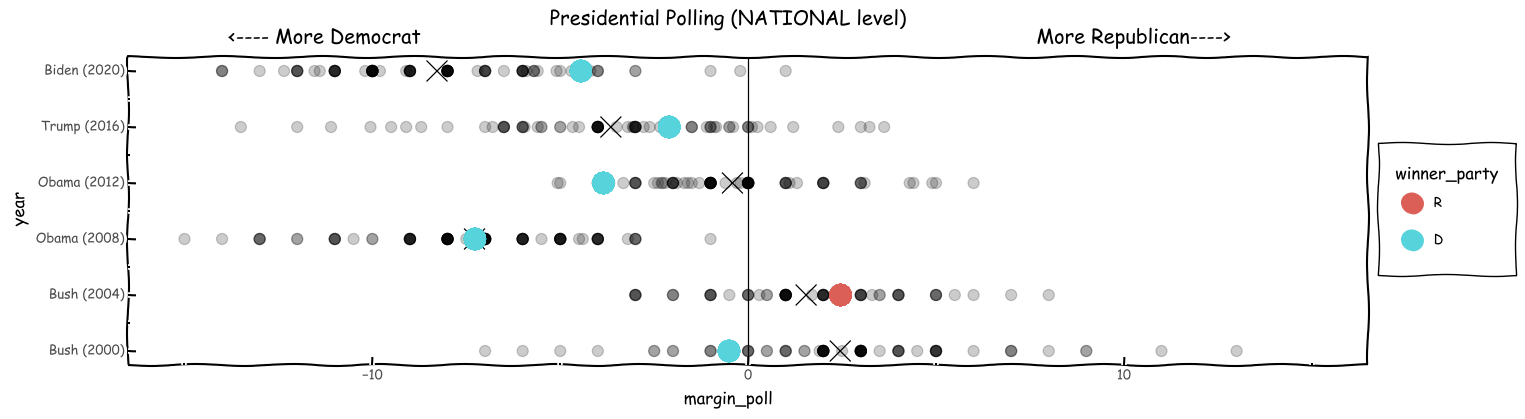

<ggplot: (350472078)>

In [7]:
display(
    ggplot(polls_to_analyze, aes(x='margin_poll', y='year'))
     + geom_point(size=4, alpha=.2)
     + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + scale_y_continuous(breaks=list(range(2000,2024,4)), 
                          labels=list(reversed(['Biden (2020)', 'Trump (2016)', 'Obama (2012)', 'Obama (2008)', 'Bush (2004)', 'Bush (2000)'])))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title='Presidential Polling (NATIONAL level)\n <---- More Democrat                                                                                                       More Republican---->')
)

# Plotting "bias" rather than margin, since we care about how far off the poll was from the actual result
# display( 
#     ggplot(polls_to_analyze, aes(x='bias', y='year'))
#      + geom_point(size=4, alpha=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='bias').reset_index(), shape='x', size=8) 
#      + geom_point(aes(x=0, color="winner_party"), size=8)
#      + geom_vline(aes(xintercept=0))
#      + scale_y_continuous(breaks=list(range(2000,2024,4)), 
#                           labels=list(reversed(['Biden (2020)', 'Trump (2016)', 'Obama (2012)', 'Obama (2008)', 'Bush (2004)', 'Bush (2000)'])))
#      + theme_xkcd()
#      + xlim(-15,15)
#      + theme(figure_size=(16, 4)) 
#      + labs(title='Presidential Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

# )

### What do you notice about this chart?

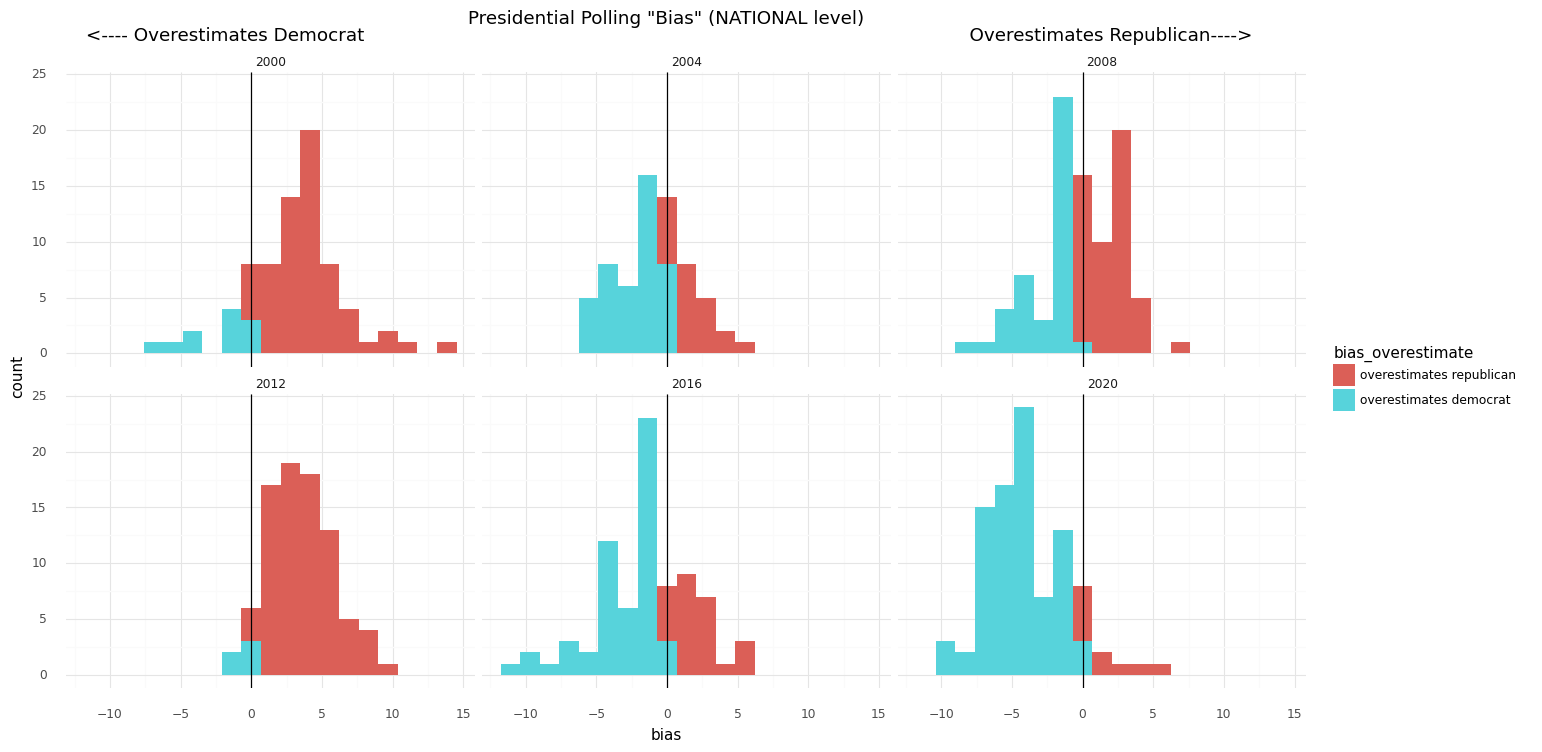

<ggplot: (350715290)>

In [8]:
# Here is another view
(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias_overestimate'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_wrap('~year')
     + theme(figure_size=(16, 8)) 
     + labs(title='Presidential Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What have we noticed about the presidential polls at the national level?

<details><summary> ---> DON'T CLICK ME </summary>
<p>

* Even if MoE Is +/-3 for example, in practice there are other sources of error. Histoircally polls have been more like +/-5 pts on average.
* Polls sometimes miss in the same direction in any given year.
```

</p>
</details>

### How might this impact how you report on a new poll that comes out?



<details><summary> ---> DON'T CLICK ME </summary>
<p>

* Place individual polls in their aggregate context
* Convey uncertainty appropriately

</p>
</details>

## But, we don't have one Presidential election in the U.S. ... 
...we have 50 separate ones (plus DC and some quirks in Maine and Nebraska). And the nationwide polls can only tell us so much about who might win the election. So what about state polling? Has it been getting better or worse over the years? Can we still rely on it this coming election cycle? 


In [9]:
# A quick look at the polls dataframe
presidential_state_level_polls = polls.query("type_detail=='Pres-G' and location!='US'")
presidential_state_level_polls.head(2)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party
471,6483,7952,815,2000,2000_Pres-G_FL,FL,Pres-G,Pres-G,McLaughlin & Associates,203,Live Phone,R,10/17/2000,600.0,Al Gore,222,DEM,43.0,George W. Bush,241,REP,44.0,3.0,1.0,11/7/2000,48.84,48.85,0.01,0.99,0.99,1.0,-3.534693,for Bill McCollum,overestimates republican,state,R
472,6470,7939,820,2000,2000_Pres-G_IL,IL,Pres-G,Pres-G,KRC Research,160,Live Phone,NaN,10/17/2000,600.0,Al Gore,222,DEM,45.0,George W. Bush,241,REP,43.0,4.0,-2.0,11/7/2000,54.60,42.58,-12.01,10.01,10.01,1.0,3.420487,NaN,overestimates republican,state,D


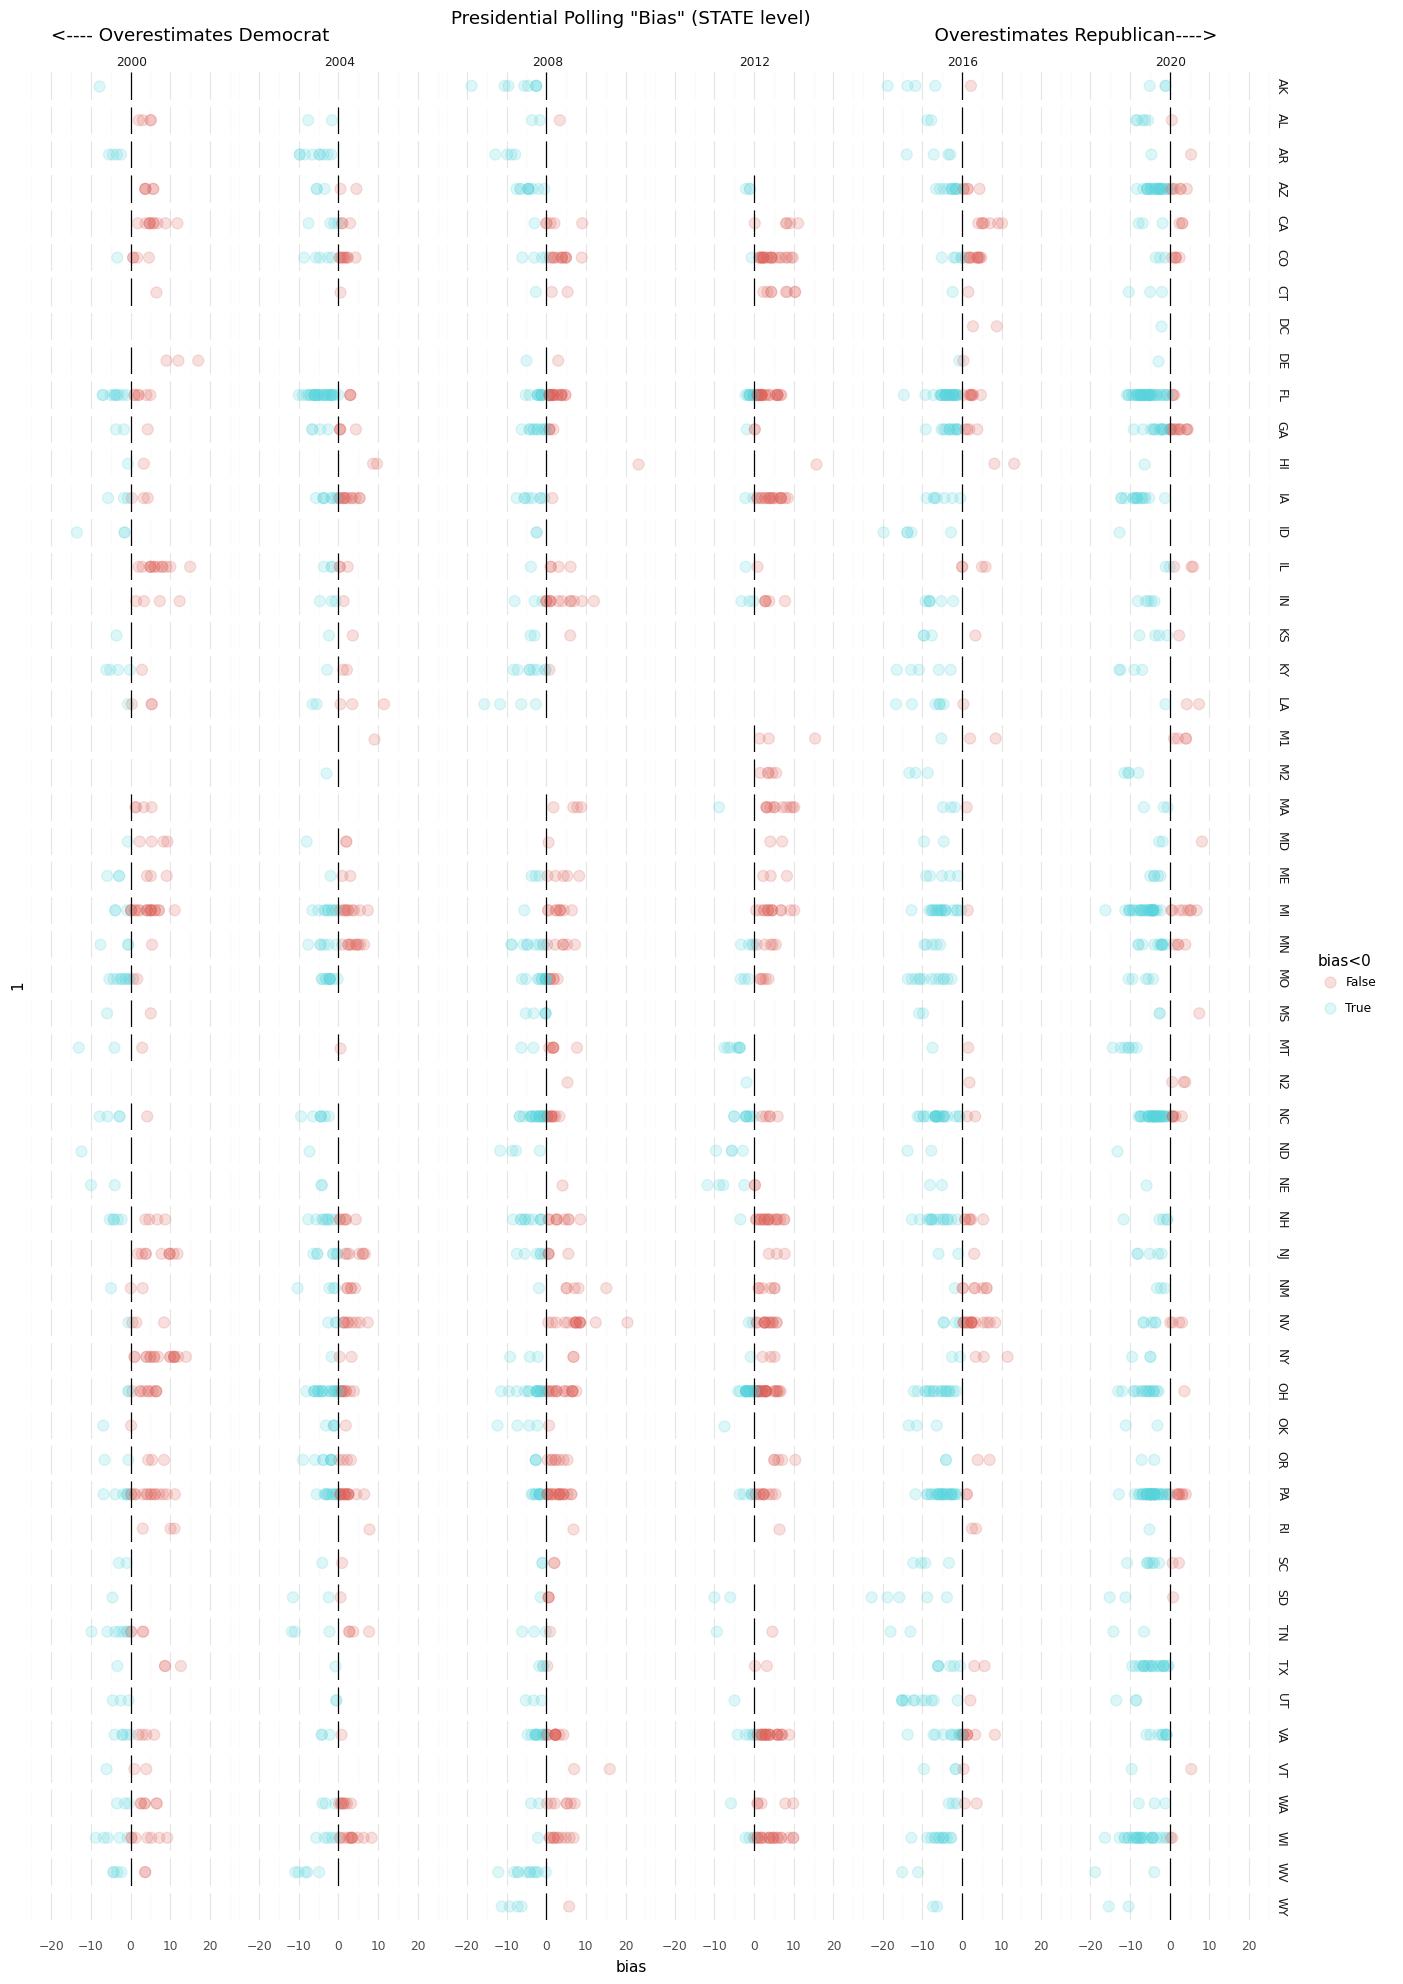

<ggplot: (351000817)>

In [10]:
(
    ggplot(presidential_state_level_polls
           , aes(x='bias', y=1, color='bias<0'))
     + geom_point(size=4, alpha=.2)
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + scale_y_continuous(breaks=list(range(2000,2024,4)))
     + facet_grid('location~year')
     + theme(figure_size=(16, 24)) 
         + labs(title='Presidential Polling "Bias" (STATE level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What have we noticed about the presidential polls at the state level compared to the national level?

<details><summary> ---> DON'T CLICK ME </summary>
<p>

* State level polls seem less accurate than national polls
* Some states have a lot more polling than others
* Polling in Hawaii is historically super inaccurate
* State level polling errors are correlated in any given year
```

</p>
</details>


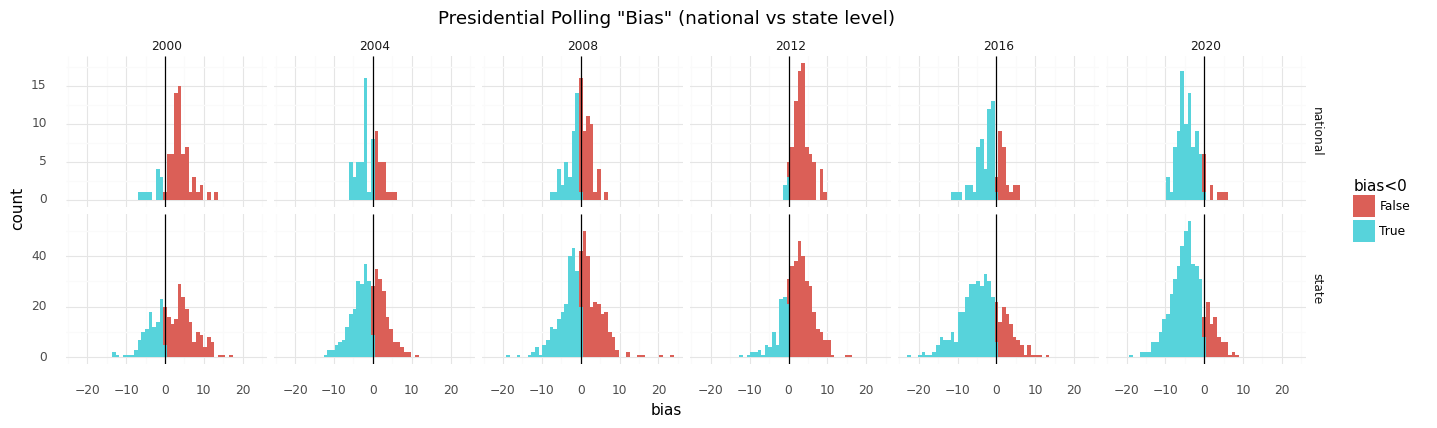

<ggplot: (381397258)>

In [11]:
# state-level presidential polls over the years
polls_to_analyze = polls.query("type_detail=='Pres-G'")

(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias<0'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_grid('national~year', scales='free_y')
     + theme(figure_size=(16, 4)) 
     + labs(title='Presidential Polling "Bias" (national vs state level)')

)

## What about polling in primary elections?

In [12]:
# Primary and general elections
polls_to_analyze = polls.query("type_detail.isin(['Pres-G', 'Pres-R', 'Pres-D']) and error.notna()")
polls_to_analyze = polls_to_analyze.query("national=='state'")

# # polls_to_analyze = polls_to_analyze.query("location.isin(@swing_states_2020)")
# display(
#     ggplot(polls_to_analyze, aes(x='error'))
#      + geom_histogram()
#      + theme_minimal()
#      + facet_grid('type_detail~year', scales='free_y')
#      + theme(figure_size=(16, 4)) 
#      + labs(title='Presidential Polling "Bias" (STATE level)')

# )

display(
    polls_to_analyze.pivot_table(index='type_detail', values='error', columns='year',aggfunc='mean').T.round(1).fillna('')
)

type_detail,Pres-D,Pres-G,Pres-R
year,,,
2000,6.5,4.6,8.8
2004,7.1,3.3,
2008,7.7,3.6,7.0
2012,,3.7,8.6
2016,10.5,5.4,8.3
2020,10.3,5.0,7.2


## And how about Senate, House, Governor, etc...?

In [13]:
(
    polls
    .pivot_table(index=['type_simple'], values='error', columns='national',aggfunc='mean')
    .round(1)
    .fillna('')
)


national,national,state
type_simple,,
Gov-G,,5.1
House-G,4.0,6.3
Pres-G,3.1,4.3
Pres-P,,8.4
Sen-G,,5.2


# Are polls becoming less accurate over time? 

In [14]:
(
    polls.query('year%2==0')
    .pivot_table(index=['type_simple', 'national'], values='error', columns='year',aggfunc='mean')
    .round(1)
    .fillna('')
    .T
)


type_simple Gov-G  House-G         Pres-G       Pres-P Sen-G
national    state national state national state  state state
year                                                        
1998          8.1      4.6   8.3                         6.8
2000          3.7      3.4   5.6      3.7   4.6    7.9   5.4
2002          5.4      5.0   5.7                         4.9
2004          3.2      4.7   5.6      2.2   3.3    7.1   5.0
2006          4.7      6.9   5.9                         5.2
2008          4.7      2.8   6.4      2.2   3.6    7.4   4.9
2010          4.7      3.2   7.2                         5.4
2012          4.7      1.8   6.1      3.5   3.7    8.6   4.7
2014          4.8      4.5   7.0                         5.3
2016          6.2      2.7   6.9      2.9   5.4    9.4   5.4
2018          4.7      3.7   5.1                         4.1
2020          7.0      4.7   7.3      4.2   5.0   10.2   5.6

# Part 2: Statistical Treatment

Statistical treatment can help you get more out of a dataset! Sometimes the polls miss, but have consistent biases one way or another. If we can detect these patterns, we can correct for them and get more out of the data. Here is one example of how. Let's take a look at what we know about each pollster

- Pollster Ratings: https://projects.fivethirtyeight.com/pollster-ratings/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/
- Latest Update: https://fivethirtyeight.com/features/the-state-of-the-polls-2019/

In [15]:
pollster_ratings = pd.read_csv('pollster-ratings.csv').set_index('Pollster Rating ID')
pollster_ratings.head()

,Rank,Pollster,Polls Analyzed,NCPP/AAPOR/Roper,Banned by 538,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,Races Called Correctly,Misses Outside MOE,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,# of Polls for Bias Analysis,Bias,House Effect,Average Distance from Polling Average (ADPA),Herding Penalty
Pollster Rating ID,,,,,,,,,,,,,,,,,,,,
304,1,Selzer & Co.,50,yes,no,-1.164872,A+,0.106846,0.780000,0.240000,4.562133,5.959977,-1.392989,-1.623991,-1.006764,33,0.201305,-0.243631,5.339089,0.000000
3,2,ABC News/The Washington Post,82,yes,no,-0.991960,A+,0.919807,0.737805,0.085366,3.053507,4.972745,-1.914383,-1.328717,-0.980676,77,1.256719,1.231279,3.827492,0.132349
448,3,Siena College/The New York Times Upshot,83,yes,no,-0.954452,A+,1.142941,0.728916,0.204819,4.352682,5.364920,-1.007384,-1.309741,-1.055391,82,1.422586,0.231204,3.574594,0.225522
144,4,IBD/TIPP,31,yes,no,-0.938424,A+,-0.832351,0.806452,0.032258,2.085002,4.009343,-1.919487,-1.512109,-0.792614,31,-1.587916,-1.814818,3.704195,0.099455
94,5,Field Research Corp. (Field Poll),25,yes,no,-0.906695,A/B,-0.682868,1.000000,0.200000,4.103997,5.990497,-1.881646,-2.473643,-0.923134,18,-2.455076,0.725441,4.752571,0.000000


> **Mean-Reverted Bias** - A pollster's historical average statistical bias toward Democratic or Republican candidates, reverted to a mean of zero based on the number of polls in the database. A score of "R +1.5", for example, indicates that the pollster has historically overrated the performance of the Republican candidate.

> **House Effect** The average amount by which the firm's polls have shown more favorable results for Democratic or Republican candidates as compared to other surveys of the same race. For instance, if a poll showed the Republican ahead by 5 percentage points, and the average of other polls in the same race showed the Republican ahead by 2 percentage points, it would have a House Effect score of R+3. This is not the same thing as the Bias calculation -- House Effect compares a poll to other surveys of the same races rather than against actual results. Cases in which the firm was the only one to survey the race are not included in the calculation.

> **Average Distance from Polling Average (ADPA)** How far the firm's average poll differed from the average of other polls in the field at the time it was released. Specifically, the average is calculated based on the most recent poll (among polls in the pollster rating database) from each other firm that polled the race, provided that the poll was not partisan and that the pollster is not banned by FiveThirtyEight. A low ADPA is potential evidence of herding.

> **Herding Penalty** A herding penalty is triggered when a firm's ADPA is lower than the theoretical minimum based on the sampling error in it's polls. For instance, if a pollster's ADPA is 3.5, but you'd expect its polls to deviate by a minimum of 4.5 points from the polling average given sampling error based on its sample sizes, the firm would receive a herding penalty of 1 point. This penalty is added to a firm's Advanced Plus-Minus score before calculating Predictive Plus-Minus.


Beware of "Unskewing" polls

In [44]:
pres_polls_by_state.query("year==2016 and location=='HI'")\
    [['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'error', 'error_adjusted']]\
    .assign(better=lambda df: df.error_adjusted < df.error)

,pollster,grade,margin_actual,margin_poll,margin_poll_adjusted,mrb,error,error_adjusted,better
8381,SurveyMonkey,C,-32.18,-19.0,-23.742323,4.742323,13.18,8.437677,True
8780,SurveyMonkey,C,-32.18,-24.0,-28.742323,4.742323,8.18,3.437677,True


In [45]:
pres_polls_by_state.query("year==2016 and location=='GA'")\
    [['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'error', 'error_adjusted']]\
    .assign(better=lambda df: df.error_adjusted < df.error)

,pollster,grade,margin_actual,margin_poll,margin_poll_adjusted,mrb,error,error_adjusted,better
8011,Lucid,B-,5.13,-4.00,-5.923144,1.923144,9.13,11.053144,False
8045,Abt Associates,A/B,5.13,2.00,1.186663,0.813337,3.13,3.943337,False
8065,Landmark Communications,A,5.13,4.00,2.585696,1.414304,1.13,2.544304,False
8066,Opinion Savvy/InsiderAdvantage,B,5.13,4.00,2.865828,1.134172,1.13,2.264172,False
8165,Quinnipiac University,A-,5.13,0.50,-0.048557,0.548557,4.63,5.178557,False
8259,SurveyUSA,A,5.13,7.00,6.951531,0.048469,1.87,1.821531,True
8380,SurveyMonkey,C,5.13,2.00,-2.742323,4.742323,3.13,7.872323,False
8497,Emerson College,A-,5.13,9.00,8.156753,0.843247,3.87,3.026753,True
8546,Marist College,A,5.13,1.00,0.893012,0.106988,4.13,4.236988,False
8683,Landmark Communications,A,5.13,2.00,0.585696,1.414304,3.13,4.544304,False


Uh oh, what happened here? 

Statistical treatments don't necessarily improve each individual poll result. But on average, when incoporated into your analysis they will help you get more information from the aggregate of your data.

Still, in the aggregate:
* you're better off looking at the average of the polls rather than one poll.
* you're better off looking at the adjusted average than a raw average *IF* the adjustment is done well
* this is only one statsitical treatment! Remember how Hawaii polls tend to underestimate how well Democrats will do? We have adjusted for the pollster's average bias, but have not accounted for factors like that. And there are so many other things to consider! When you start adjusting for lots of factors and also incorporating other factors known to be predictive of elections, you get an election forecast.

# Election Forecast Models

Let's talk about our election forecasts, which apply a lot of statistical treatments based on what we know about the nature of politics and political data in the U.S.


## Forecasts

### 2020 Forecast

- Forecast: https://projects.fivethirtyeight.com/2020-election-forecast/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/


### 2016 Forecast

- Forecast: https://projects.fivethirtyeight.com/2016-election-forecast/
- Methodology: https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/
- Analysis: https://projects.fivethirtyeight.com/2016-election-forecast/articles/?ex_cid=2016-forecast

### 2018 Forecast

- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/senate
- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house


## Polls Stories from 2016

These help elucidate how we turn analysis, like what you just did above, into insights for our readers.

- https://fivethirtyeight.com/features/how-much-the-polls-missed-by-in-every-state/
- https://fivethirtyeight.com/features/pollsters-probably-didnt-talk-to-enough-white-voters-without-college-degrees/
- https://fivethirtyeight.com/features/what-a-difference-2-percentage-points-makes/
- https://fivethirtyeight.com/features/shy-voters-probably-arent-why-the-polls-missed-trump/
- https://fivethirtyeight.com/features/the-polls-missed-trump-we-asked-pollsters-why/
- https://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/
- https://fivethirtyeight.com/features/the-polls-are-all-right/
- https://fivethirtyeight.com/features/trump-is-just-a-normal-polling-error-behind-clinton/



## Some other folks

- [CNN](https://www.cnn.com/election/2018/forecast)
- [Daily Kos](https://elections.dailykos.com/)
- [New York Times - Real Time Polling!](https://www.nytimes.com/interactive/2018/upshot/elections-polls.html)


# Visualizing Uncertainty

- FiveThirtyEight in [2010](https://www.nytimes.com/elections/2010/forecasts/senate.html), [2014](https://fivethirtyeight.com/interactives/senate-forecast/), [2016](https://projects.fivethirtyeight.com/2016-election-forecast/), [2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/)
    * I think 2010 still works in Safari...
- New York Times
    * The Spinners https://www.nytimes.com/2014/11/01/upshot/how-confirmation-bias-can-lead-to-a-spinning-of-wheels.html
    * The Needle https://www.youtube.com/watch?v=iq5rW6zYeP4
- [Huffpost's](http://elections.huffingtonpost.com/pollster) custom charts.

